In [3]:
import nbformat
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import nbformat
import os

In [4]:
# --- 1) Load and prepare data ---
# dynamically construct data path relative to notebook
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "cleaned_train_with_amenities.csv")
df = pd.read_csv(data_path)

C:\Users\yuhon\AppData\Local\Temp\ipykernel_11212\4025959675.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [6]:
# --- 2) Feature engineering ---
# get floor range ---
floor_range_mapping  = {
    '01 to 03': 2,
    '04 to 06': 7,
    '07 to 09': 8,
    '10 to 12': 11,
    '13 to 15': 14,
    '16 to 18': 17,
    '19 to 21': 20,
    '22 to 24': 23,
    '25 to 27': 26,
    '28 to 30': 29,
    '31 to 33': 32,
    '34 to 36': 35,
    '37 to 39': 38,
    '40 to 42': 41,
    '43 to 45': 44,
    '46 to 48': 47,
    '49 to 51': 50
}
reversed_mapping = {v: k for k, v in floor_range_mapping.items()}
df['floor_range'] = df['height'].map(reversed_mapping)
# get relative_height
fr = df['floor_range'].str.extract(r'(?i)(\d+)\s*to\s*(\d+)', expand=True).astype(float)
df['floor_avg'] = fr.mean(axis=1)
df['relative_height'] = df['floor_avg'] / df['max_floor']


use_cols = [
    'latitude',
    'longitude',
    'resale_price',
    'floor_area_sqm',
    'age_at_sale',
    'month_from2017',
    'flat_type_num',
    'flat_model_num',
    'mrt_distance',
    'hawker_distance',
    'mall_distance',
    'primary_school_distance',
    'secondary_school_distance',
    'relative_height',
    'town'
]

dfn2 = df[use_cols].dropna().copy()

# mark categorical explicitly
dfn2["flat_type_num"] = dfn2["flat_type_num"].astype("category")
dfn2["flat_model_num"] = dfn2["flat_model_num"].astype("category")
dfn2["town"] = dfn2["town"].astype("category")

Best RMSE = 26,012 with {'learning_rate': 0.1, 'min_data_in_leaf': 80, 'num_leaves': 255}


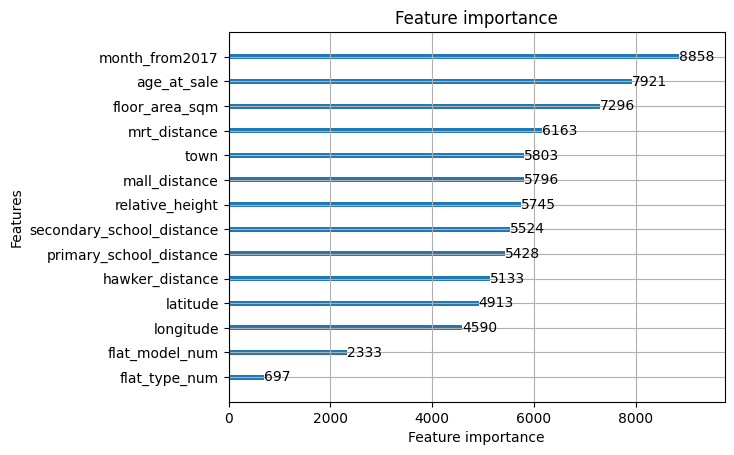

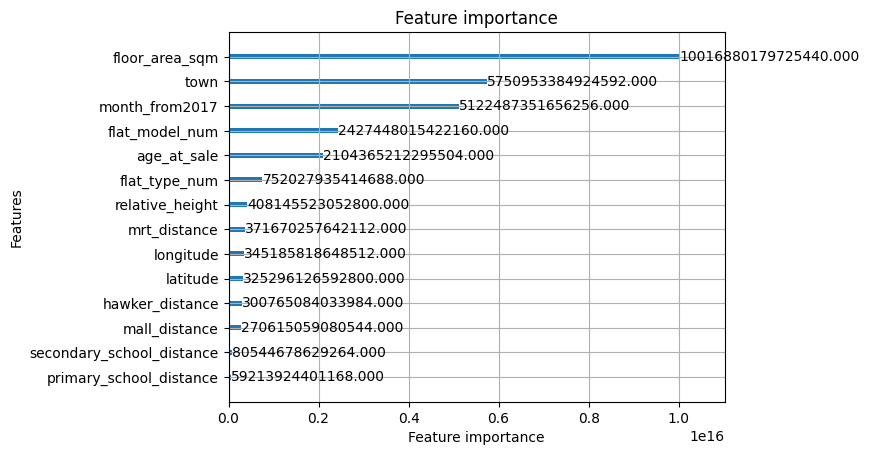

In [12]:
# --- 3) Train model ---

X = dfn2.drop(columns=["resale_price"])
y = dfn2["resale_price"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "num_leaves": [63, 127, 255, 511],
    "min_data_in_leaf": [10, 20, 40, 80],
    "learning_rate": [0.05, 0.1, 0.2]
}

model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=300,
    verbose=-1
)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=kf,
    n_jobs=-1
)

grid.fit(X, y, categorical_feature=["flat_type_num", "flat_model_num", "town"])

best_rmse = -grid.best_score_
best_params = grid.best_params_
print(f"Best RMSE = {best_rmse:,.0f} with {best_params}")

# --- 4) Feature importance plots ---
lgb.plot_importance(grid.best_estimator_, importance_type="split", max_num_features=20)
plt.show()

lgb.plot_importance(grid.best_estimator_, importance_type="gain", max_num_features=20)
plt.show()